Загрузка данных BTCUSDT с 2025-01-01 по 2025-05-30...
Загружено 43000 записей

Параметры модели:
Средняя доходность (μ): 0.000003
Волатильность (σ): 0.001615
Годовая волатильность: 43.51%

Выполнение 1000 симуляций...


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1097.49it/s]



=== РЕЗУЛЬТАТЫ АНАЛИЗА ===

Начальная цена: $105,516.73

Статистики конечных цен:
Средняя: $108,692.79
Медиана: $108,344.08
Стандартное отклонение: $15,790.81

Доходность за период:
Средняя: 3.01%
Медиана: 2.68%

Квантили цен:
5%: $83,354.23
25%: $97,615.49
50%: $108,344.08
75%: $119,127.50
95%: $134,700.05

Квантили доходности:
5%: -21.00%
25%: -7.49%
50%: 2.68%
75%: 12.90%
95%: 27.66%

Вероятности:
Вероятность прибыли: 57.1%
Вероятность убытка > 10%: 18.1%
Вероятность прибыли > 10%: 31.4%


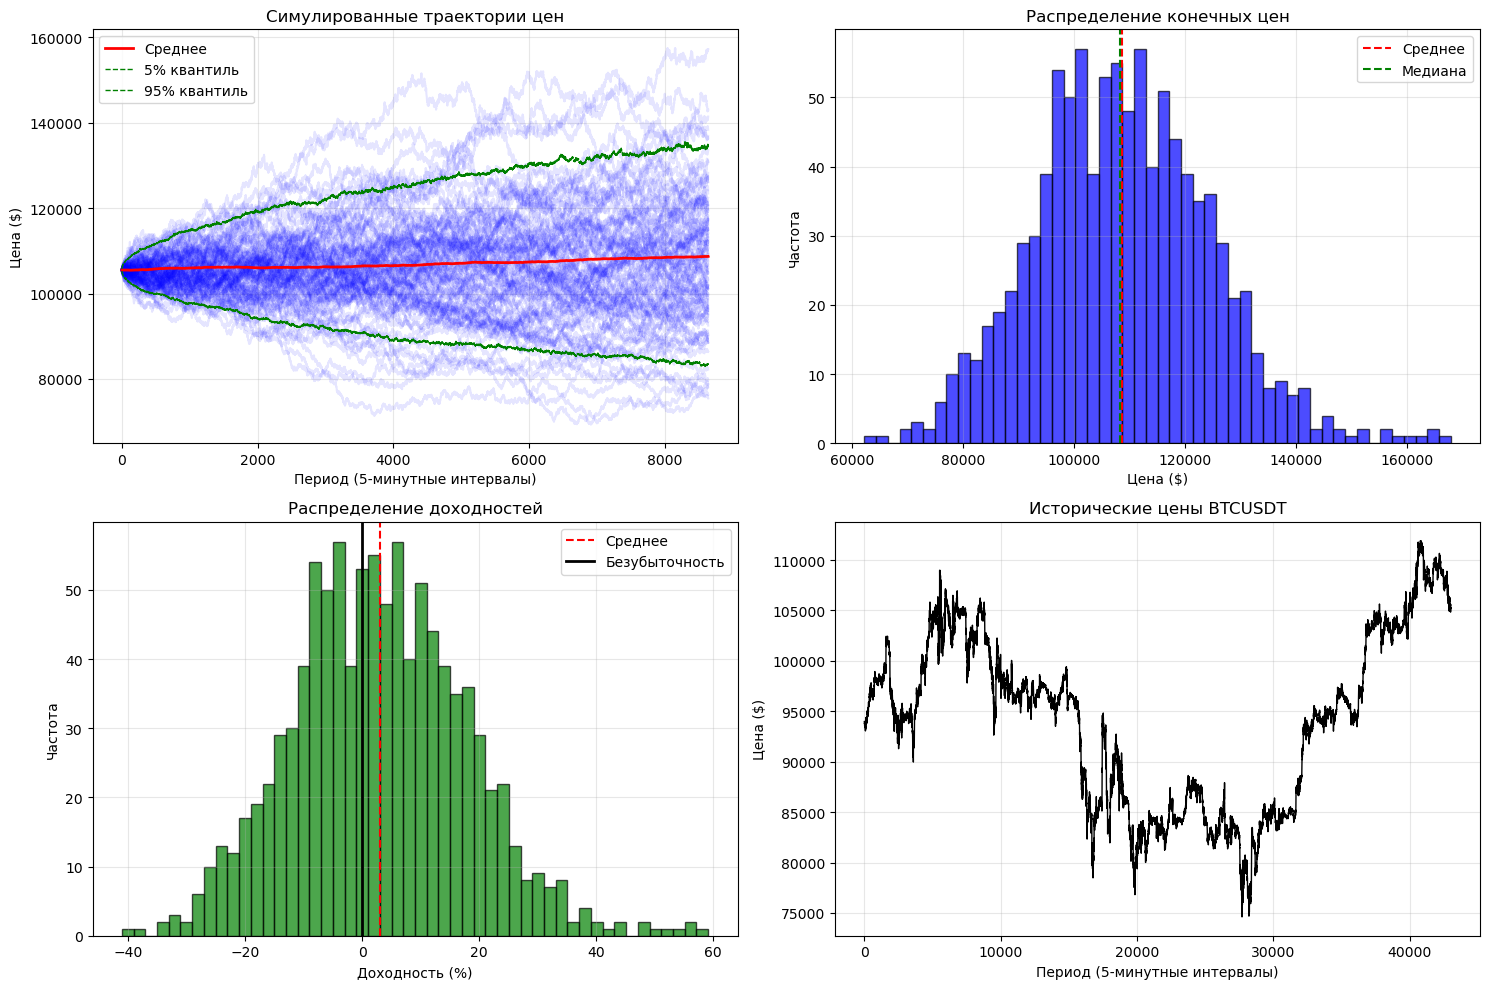


=== Value at Risk (VaR) ===
VaR 95%: -21.00% (с вероятностью 95% убыток не превысит 21.00%)
VaR 99%: -28.53% (с вероятностью 99% убыток не превысит 28.53%)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import requests
import time
from tqdm import tqdm

def fetch_binance_data(symbol='BTCUSDT', interval='5m', start_date='2025-01-01', end_date='2025-05-30'):
    """
    Загружает исторические данные с Binance API
    """
    # Конвертируем даты в timestamp (миллисекунды)
    start_timestamp = int(datetime.strptime(start_date, '%Y-%m-%d').timestamp() * 1000)
    end_timestamp = int(datetime.strptime(end_date, '%Y-%m-%d').timestamp() * 1000)
    
    # URL для Binance API
    url = 'https://api.binance.com/api/v3/klines'
    
    all_data = []
    current_start = start_timestamp
    
    print(f"Загрузка данных {symbol} с {start_date} по {end_date}...")
    
    while current_start < end_timestamp:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': current_start,
            'limit': 1000  # Максимум 1000 свечей за запрос
        }
        
        try:
            response = requests.get(url, params=params)
            response.raise_for_status()
            data = response.json()
            
            if not data:
                break
                
            all_data.extend(data)
            
            # Обновляем начальное время для следующего запроса
            current_start = data[-1][0] + 1
            
            # Небольшая задержка, чтобы не перегружать API
            time.sleep(0.1)
            
        except Exception as e:
            print(f"Ошибка при загрузке данных: {e}")
            break
    
    # Преобразуем в DataFrame
    df = pd.DataFrame(all_data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_volume', 'trades', 'taker_buy_base',
        'taker_buy_quote', 'ignore'
    ])
    
    # Конвертируем типы данных
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['close'] = df['close'].astype(float)
    df['volume'] = df['volume'].astype(float)
    
    # Фильтруем по конечной дате
    df = df[df['timestamp'] <= end_date + ' 23:59:59']
    
    print(f"Загружено {len(df)} записей")
    
    return df[['timestamp', 'close', 'volume']]

def calculate_returns(prices):
    """
    Рассчитывает логарифмические доходности
    """
    return np.log(prices / prices.shift(1)).dropna()

def monte_carlo_simulation(initial_price, returns, n_periods, n_simulations=1000):
    """
    Выполняет симуляцию Монте-Карло
    
    Parameters:
    - initial_price: начальная цена
    - returns: исторические доходности для расчета параметров
    - n_periods: количество периодов для симуляции
    - n_simulations: количество симуляций
    """
    # Рассчитываем параметры для random walk
    mu = returns.mean()  # среднее значение доходности
    sigma = returns.std()  # стандартное отклонение доходности
    
    # Создаем массив для хранения результатов
    simulations = np.zeros((n_simulations, n_periods))
    
    print(f"\nПараметры модели:")
    print(f"Средняя доходность (μ): {mu:.6f}")
    print(f"Волатильность (σ): {sigma:.6f}")
    print(f"Годовая волатильность: {sigma * np.sqrt(252 * 24 * 12):.2%}")  # 252 дня * 24 часа * 12 пятиминуток
    
    # Выполняем симуляции
    print(f"\nВыполнение {n_simulations} симуляций...")
    for i in tqdm(range(n_simulations)):
        # Генерируем случайные доходности
        random_returns = np.random.normal(mu, sigma, n_periods)
        
        # Рассчитываем цены через кумулятивное произведение
        price_path = initial_price * np.exp(np.cumsum(random_returns))
        simulations[i] = price_path
    
    return simulations

def analyze_results(simulations, initial_price, final_real_price=None):
    """
    Анализирует результаты симуляции
    """
    final_prices = simulations[:, -1]
    
    # Рассчитываем статистики
    mean_final_price = np.mean(final_prices)
    median_final_price = np.median(final_prices)
    std_final_price = np.std(final_prices)
    
    # Рассчитываем доходности
    returns = (final_prices / initial_price - 1) * 100
    mean_return = np.mean(returns)
    median_return = np.median(returns)
    
    # Квантили
    percentiles = [5, 25, 50, 75, 95]
    price_percentiles = np.percentile(final_prices, percentiles)
    return_percentiles = np.percentile(returns, percentiles)
    
    print("\n=== РЕЗУЛЬТАТЫ АНАЛИЗА ===")
    print(f"\nНачальная цена: ${initial_price:,.2f}")
    if final_real_price:
        print(f"Реальная конечная цена: ${final_real_price:,.2f}")
        print(f"Реальная доходность: {(final_real_price/initial_price - 1)*100:.2f}%")
    
    print(f"\nСтатистики конечных цен:")
    print(f"Средняя: ${mean_final_price:,.2f}")
    print(f"Медиана: ${median_final_price:,.2f}")
    print(f"Стандартное отклонение: ${std_final_price:,.2f}")
    
    print(f"\nДоходность за период:")
    print(f"Средняя: {mean_return:.2f}%")
    print(f"Медиана: {median_return:.2f}%")
    
    print(f"\nКвантили цен:")
    for p, v in zip(percentiles, price_percentiles):
        print(f"{p}%: ${v:,.2f}")
    
    print(f"\nКвантили доходности:")
    for p, v in zip(percentiles, return_percentiles):
        print(f"{p}%: {v:.2f}%")
    
    # Вероятности
    prob_profit = (returns > 0).sum() / len(returns) * 100
    prob_loss_10 = (returns < -10).sum() / len(returns) * 100
    prob_gain_10 = (returns > 10).sum() / len(returns) * 100
    
    print(f"\nВероятности:")
    print(f"Вероятность прибыли: {prob_profit:.1f}%")
    print(f"Вероятность убытка > 10%: {prob_loss_10:.1f}%")
    print(f"Вероятность прибыли > 10%: {prob_gain_10:.1f}%")
    
    return {
        'final_prices': final_prices,
        'returns': returns,
        'statistics': {
            'mean_price': mean_final_price,
            'median_price': median_final_price,
            'mean_return': mean_return,
            'median_return': median_return
        }
    }

def plot_results(simulations, real_prices, results):
    """
    Визуализация результатов
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Траектории цен
    ax1 = axes[0, 0]
    # Показываем первые 100 симуляций для наглядности
    for i in range(min(100, len(simulations))):
        ax1.plot(simulations[i], alpha=0.1, color='blue')
    
    # Добавляем среднюю и квантили
    mean_path = np.mean(simulations, axis=0)
    q5_path = np.percentile(simulations, 5, axis=0)
    q95_path = np.percentile(simulations, 95, axis=0)
    
    ax1.plot(mean_path, color='red', linewidth=2, label='Среднее')
    ax1.plot(q5_path, color='green', linewidth=1, linestyle='--', label='5% квантиль')
    ax1.plot(q95_path, color='green', linewidth=1, linestyle='--', label='95% квантиль')
    
    ax1.set_title('Симулированные траектории цен')
    ax1.set_xlabel('Период (5-минутные интервалы)')
    ax1.set_ylabel('Цена ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Распределение конечных цен
    ax2 = axes[0, 1]
    ax2.hist(results['final_prices'], bins=50, alpha=0.7, color='blue', edgecolor='black')
    ax2.axvline(results['statistics']['mean_price'], color='red', linestyle='--', label='Среднее')
    ax2.axvline(results['statistics']['median_price'], color='green', linestyle='--', label='Медиана')
    ax2.set_title('Распределение конечных цен')
    ax2.set_xlabel('Цена ($)')
    ax2.set_ylabel('Частота')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Распределение доходностей
    ax3 = axes[1, 0]
    ax3.hist(results['returns'], bins=50, alpha=0.7, color='green', edgecolor='black')
    ax3.axvline(results['statistics']['mean_return'], color='red', linestyle='--', label='Среднее')
    ax3.axvline(0, color='black', linestyle='-', linewidth=2, label='Безубыточность')
    ax3.set_title('Распределение доходностей')
    ax3.set_xlabel('Доходность (%)')
    ax3.set_ylabel('Частота')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Исторические цены
    ax4 = axes[1, 1]
    ax4.plot(real_prices.values, color='black', linewidth=1)
    ax4.set_title('Исторические цены BTCUSDT')
    ax4.set_xlabel('Период (5-минутные интервалы)')
    ax4.set_ylabel('Цена ($)')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def main():
    # Параметры
    symbol = 'BTCUSDT'
    start_date = '2025-01-01'
    end_date = '2025-05-30'
    interval = '5m'
    n_simulations = 1000
    
    # Загружаем данные
    df = fetch_binance_data(symbol, interval, start_date, end_date)
    
    # Рассчитываем доходности
    returns = calculate_returns(df['close'])
    
    # Начальная цена - последняя известная цена
    initial_price = df['close'].iloc[-1]
    
    # Количество периодов для симуляции (например, следующие 30 дней)
    # 30 дней * 24 часа * 12 пятиминутных интервалов = 8640 периодов
    n_periods = 30 * 24 * 12
    
    # Выполняем симуляцию
    simulations = monte_carlo_simulation(
        initial_price=initial_price,
        returns=returns,
        n_periods=n_periods,
        n_simulations=n_simulations
    )
    
    # Анализируем результаты
    results = analyze_results(simulations, initial_price)
    
    # Визуализация
    plot_results(simulations, df['close'], results)
    
    # Дополнительный анализ: Value at Risk (VaR)
    var_95 = np.percentile(results['returns'], 5)
    var_99 = np.percentile(results['returns'], 1)
    
    print(f"\n=== Value at Risk (VaR) ===")
    print(f"VaR 95%: {var_95:.2f}% (с вероятностью 95% убыток не превысит {abs(var_95):.2f}%)")
    print(f"VaR 99%: {var_99:.2f}% (с вероятностью 99% убыток не превысит {abs(var_99):.2f}%)")

if __name__ == "__main__":
    main()

Загрузка данных SOLUSDT с 2025-01-01 по 2025-05-29...
Загружено 14292 записей

Выполнение 50 симуляций Монте-Карло...


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:16<00:00,  1.52s/it]


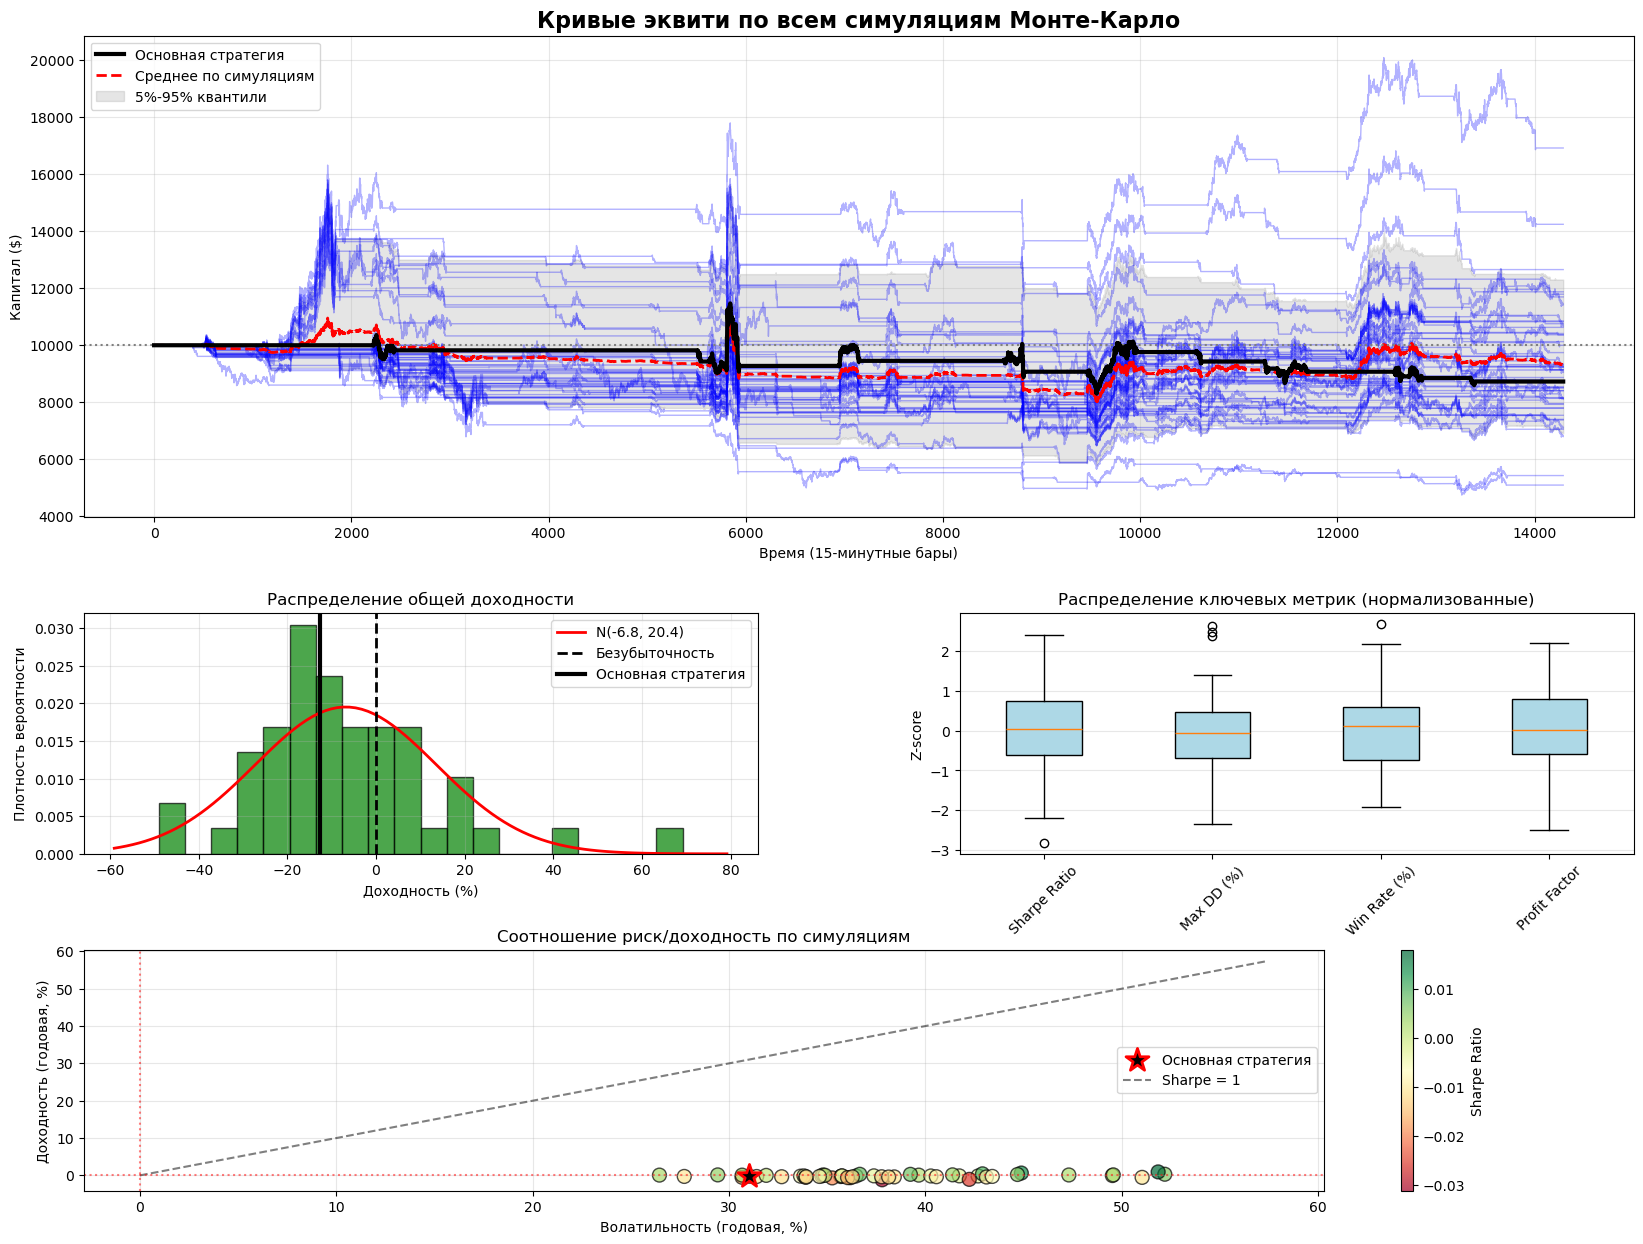


=== РЕЗУЛЬТАТЫ МОНТЕ-КАРЛО СИМУЛЯЦИИ ===

Основная стратегия (без шума):
Общая доходность: -12.73%
Годовая доходность: -0.24%
Волатильность: 31.03%
Sharpe Ratio: -0.008
Максимальная просадка: -27.53%
Win Rate: 7.47%
Profit Factor: 0.97

Статистика по всем симуляциям:
Средняя доходность: -6.81%
Медианная доходность: -8.67%
Худшая доходность: -49.04%
Лучшая доходность: 69.19%
Вероятность прибыли: 32.0%

✅ HTML график сохранен в файл 'trades_visualization.html'
Откройте его в браузере для интерактивного просмотра входов и выходов


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import requests
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Параметры симуляции Монте-Карло
MONTE_CARLO_SIMULATIONS = 50  # Количество симуляций
MONTE_CARLO_SEED_BASE = 42  # Базовый seed для воспроизводимости результатов
PRICE_NOISE_FACTOR = 0.005  # Фактор ценового шума (0.5% от цены)
EXECUTION_PROBABILITY = 0.85  # Вероятность исполнения ордера (85%)
ORDER_DISTANCE_NOISE = 0.005  # Шум в расстоянии между ордерами (±0.5%)
VOLUME_NOISE_FACTOR = 0.1  # Шум в объеме ордеров (±10%)
SLIPPAGE_FACTOR = 0.005  # Фактор проскальзывания (±0.5% от цены)
VOLATILITY_SIGMA = 0.09  # Волатильность (σ) - 9% дневная волатильность
VOLATILITY_VARIATION = 0.6  # Вариация волатильности между симуляциями (±60%)
DRIFT_MU = 0.005  # Дрейф/тренд (μ) - 0.5% положительный дрейф
DRIFT_VARIATION = 2.0  # Вариация дрейфа между симуляциями (может менять направление)
JUMP_PROBABILITY = 0.006  # Вероятность скачка на каждой свече (0.6%)
JUMP_MEAN_SIZE = 0.01  # Средний размер скачка (1% от цены)
JUMP_STD_SIZE = 0.009  # Стандартное отклонение размера скачка
JUMP_DIRECTION_BIAS = 0.5  # Смещение направления скачков (0.5 = нейтрально)

# Параметры стратегии
FAST_SMA_PERIOD = 50  # Период быстрой SMA
SLOW_SMA_PERIOD = 230  # Период медленной SMA
TREND_LOOKBACK = 2  # Количество свечей для проверки тренда
INITIAL_CAPITAL = 10000  # Начальный капитал
POSITION_SIZE = 0.95  # Размер позиции (95% от капитала)
COMMISSION = 0.0003  # Комиссия (0.03%)

def fetch_binance_data(symbol='SOLUSDT', interval='15m', start_date='2024-01-01', end_date='2025-05-29'):
    """
    Загружает исторические данные с Binance API
    """
    # Конвертируем даты в timestamp (миллисекунды)
    start_timestamp = int(datetime.strptime(start_date, '%Y-%m-%d').timestamp() * 1000)
    end_timestamp = int(datetime.strptime(end_date, '%Y-%m-%d').timestamp() * 1000)
    
    # URL для Binance API
    url = 'https://api.binance.com/api/v3/klines'
    
    all_data = []
    current_start = start_timestamp
    
    print(f"Загрузка данных {symbol} с {start_date} по {end_date}...")
    
    while current_start < end_timestamp:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': current_start,
            'limit': 1000  # Максимум 1000 свечей за запрос
        }
        
        try:
            response = requests.get(url, params=params)
            response.raise_for_status()
            data = response.json()
            
            if not data:
                break
                
            all_data.extend(data)
            
            # Обновляем начальное время для следующего запроса
            current_start = data[-1][0] + 1
            
            # Небольшая задержка, чтобы не перегружать API
            time.sleep(0.1)
            
        except Exception as e:
            print(f"Ошибка при загрузке данных: {e}")
            break
    
    # Преобразуем в DataFrame
    df = pd.DataFrame(all_data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_volume', 'trades', 'taker_buy_base',
        'taker_buy_quote', 'ignore'
    ])
    
    # Конвертируем типы данных
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['open'] = df['open'].astype(float)
    df['high'] = df['high'].astype(float)
    df['low'] = df['low'].astype(float)
    df['close'] = df['close'].astype(float)
    df['volume'] = df['volume'].astype(float)
    
    # Фильтруем по конечной дате
    df = df[df['timestamp'] <= end_date + ' 23:59:59']
    
    print(f"Загружено {len(df)} записей")
    
    return df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]

def apply_monte_carlo_noise(df, simulation_num):
    """
    Применяет различные типы шума к ценовым данным для симуляции Монте-Карло
    """
    np.random.seed(MONTE_CARLO_SEED_BASE + simulation_num)
    
    # Создаем копию данных
    df_noisy = df.copy()
    
    # Рассчитываем параметры для данной симуляции
    sim_volatility = VOLATILITY_SIGMA * (1 + np.random.uniform(-VOLATILITY_VARIATION, VOLATILITY_VARIATION))
    sim_drift = DRIFT_MU * (1 + np.random.uniform(-DRIFT_VARIATION, DRIFT_VARIATION))
    
    # Применяем геометрическое броуновское движение с прыжками
    n_periods = len(df)
    dt = 1 / (252 * 24 * 4)  # 15-минутные интервалы
    
    # Генерируем случайные изменения
    random_shocks = np.random.normal(0, 1, n_periods)
    price_changes = np.exp((sim_drift - 0.5 * sim_volatility**2) * dt + sim_volatility * np.sqrt(dt) * random_shocks)
    
    # Добавляем случайные прыжки
    jumps = np.zeros(n_periods)
    for i in range(n_periods):
        if np.random.random() < JUMP_PROBABILITY:
            jump_direction = 1 if np.random.random() < JUMP_DIRECTION_BIAS else -1
            jump_size = np.random.normal(JUMP_MEAN_SIZE, JUMP_STD_SIZE)
            jumps[i] = jump_direction * abs(jump_size)
    
    # Применяем изменения к ценам
    cumulative_changes = np.cumprod(price_changes * (1 + jumps))
    
    # Применяем к OHLC данным
    price_factor = cumulative_changes / cumulative_changes[0]
    df_noisy['open'] = df['open'] * price_factor
    df_noisy['high'] = df['high'] * price_factor * (1 + np.random.uniform(-PRICE_NOISE_FACTOR, PRICE_NOISE_FACTOR, n_periods))
    df_noisy['low'] = df['low'] * price_factor * (1 + np.random.uniform(-PRICE_NOISE_FACTOR, PRICE_NOISE_FACTOR, n_periods))
    df_noisy['close'] = df['close'] * price_factor
    
    # Добавляем шум к объему
    df_noisy['volume'] = df['volume'] * (1 + np.random.uniform(-VOLUME_NOISE_FACTOR, VOLUME_NOISE_FACTOR, n_periods))
    
    return df_noisy

def calculate_sma_signals(df):
    """
    Рассчитывает сигналы на основе пересечения SMA
    """
    # Рассчитываем SMA
    df['sma_fast'] = df['close'].rolling(window=FAST_SMA_PERIOD).mean()
    df['sma_slow'] = df['close'].rolling(window=SLOW_SMA_PERIOD).mean()
    
    # Рассчитываем тренд медленной SMA
    df['slow_sma_trend'] = df['sma_slow'].diff()
    
    # Проверяем условия для входа
    df['sma_crossover'] = (df['sma_fast'] > df['sma_slow']) & (df['sma_fast'].shift(1) <= df['sma_slow'].shift(1))
    
    # Проверяем тренд для последних TREND_LOOKBACK свечей
    trend_condition = True
    for i in range(1, TREND_LOOKBACK + 1):
        trend_condition = trend_condition & (df['slow_sma_trend'].shift(i) > 0)
    
    df['entry_signal'] = df['sma_crossover'] & trend_condition
    
    # Сигнал на выход
    df['exit_signal'] = (df['sma_fast'] < df['sma_slow']) & (df['sma_fast'].shift(1) >= df['sma_slow'].shift(1))
    
    return df

def backtest_strategy(df, simulation_num=0):
    """
    Выполняет бэктестирование стратегии с учетом шума исполнения
    """
    np.random.seed(MONTE_CARLO_SEED_BASE + simulation_num * 100)
    
    # Инициализация переменных
    capital = INITIAL_CAPITAL
    position = 0
    trades = []
    equity_curve = [capital]
    
    # Проходим по всем барам
    for i in range(len(df)):
        current_price = df['close'].iloc[i]
        
        # Применяем проскальзывание
        execution_price = current_price * (1 + np.random.uniform(-SLIPPAGE_FACTOR, SLIPPAGE_FACTOR))
        
        # Проверяем сигнал на вход
        if df['entry_signal'].iloc[i] and position == 0:
            # Проверяем вероятность исполнения
            if np.random.random() < EXECUTION_PROBABILITY:
                # Рассчитываем размер позиции с учетом шума
                position_value = capital * POSITION_SIZE * (1 + np.random.uniform(-ORDER_DISTANCE_NOISE, ORDER_DISTANCE_NOISE))
                position = position_value / execution_price
                capital -= position_value * (1 + COMMISSION)
                
                trades.append({
                    'timestamp': df['timestamp'].iloc[i],
                    'type': 'BUY',
                    'price': execution_price,
                    'quantity': position,
                    'capital_after': capital
                })
        
        # Проверяем сигнал на выход
        elif df['exit_signal'].iloc[i] and position > 0:
            # Проверяем вероятность исполнения
            if np.random.random() < EXECUTION_PROBABILITY:
                # Продаем позицию
                sale_value = position * execution_price
                capital += sale_value * (1 - COMMISSION)
                
                trades.append({
                    'timestamp': df['timestamp'].iloc[i],
                    'type': 'SELL',
                    'price': execution_price,
                    'quantity': position,
                    'capital_after': capital
                })
                
                position = 0
        
        # Рассчитываем текущую стоимость портфеля
        portfolio_value = capital + position * current_price
        equity_curve.append(portfolio_value)
    
    # Закрываем открытую позицию в конце
    if position > 0:
        final_price = df['close'].iloc[-1]
        capital += position * final_price * (1 - COMMISSION)
        position = 0
        equity_curve[-1] = capital
    
    return equity_curve[1:], trades

def calculate_metrics(equity_curve, df):
    """
    Рассчитывает ключевые метрики стратегии
    """
    equity_array = np.array(equity_curve)
    returns = np.diff(equity_array) / equity_array[:-1]
    
    # Основные метрики
    total_return = (equity_array[-1] / equity_array[0] - 1) * 100
    annual_return = ((equity_array[-1] / equity_array[0]) ** (252 / len(df)) - 1) * 100
    
    # Риск метрики
    volatility = np.std(returns) * np.sqrt(252 * 24 * 4)  # Годовая волатильность
    sharpe_ratio = (annual_return / 100) / volatility if volatility > 0 else 0
    
    # Максимальная просадка
    running_max = np.maximum.accumulate(equity_array)
    drawdown = (equity_array - running_max) / running_max
    max_drawdown = np.min(drawdown) * 100
    
    # Коэффициент восстановления
    recovery_factor = abs(total_return / max_drawdown) if max_drawdown != 0 else 0
    
    # Win rate
    positive_returns = returns[returns > 0]
    negative_returns = returns[returns < 0]
    win_rate = len(positive_returns) / len(returns) * 100 if len(returns) > 0 else 0
    
    # Profit factor
    gross_profit = np.sum(positive_returns)
    gross_loss = abs(np.sum(negative_returns))
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf
    
    return {
        'total_return': total_return,
        'annual_return': annual_return,
        'volatility': volatility * 100,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'recovery_factor': recovery_factor,
        'win_rate': win_rate,
        'profit_factor': profit_factor
    }

def plot_results(all_equity_curves, all_metrics, main_equity_curve, df_with_signals, trades):
    """
    Визуализация результатов
    """
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1], hspace=0.3, wspace=0.3)
    
    # 1. Кривые эквити по всем симуляциям (самый большой график)
    ax1 = fig.add_subplot(gs[0, :])
    
    # Отображаем все симуляции
    for i, equity_curve in enumerate(all_equity_curves):
        if i == 0:  # Основная кривая
            ax1.plot(equity_curve, color='black', linewidth=3, label='Основная стратегия', zorder=10)
        else:
            ax1.plot(equity_curve, alpha=0.3, color='blue', linewidth=1)
    
    # Добавляем среднюю и квантили
    all_curves_array = np.array(all_equity_curves)
    mean_curve = np.mean(all_curves_array, axis=0)
    q5_curve = np.percentile(all_curves_array, 5, axis=0)
    q95_curve = np.percentile(all_curves_array, 95, axis=0)
    
    ax1.plot(mean_curve, color='red', linewidth=2, label='Среднее по симуляциям', linestyle='--')
    ax1.fill_between(range(len(mean_curve)), q5_curve, q95_curve, alpha=0.2, color='gray', label='5%-95% квантили')
    
    ax1.set_title('Кривые эквити по всем симуляциям Монте-Карло', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Время (15-минутные бары)')
    ax1.set_ylabel('Капитал ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=INITIAL_CAPITAL, color='gray', linestyle=':', label='Начальный капитал')
    
    # 2. Распределение доходности (нормальное распределение)
    ax2 = fig.add_subplot(gs[1, 0])
    
    returns = [metrics['total_return'] for metrics in all_metrics]
    
    # Гистограмма
    n, bins, patches = ax2.hist(returns, bins=20, alpha=0.7, color='green', edgecolor='black', density=True)
    
    # Подгоняем нормальное распределение
    mu, sigma = np.mean(returns), np.std(returns)
    x = np.linspace(min(returns) - 10, max(returns) + 10, 100)
    normal_dist = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)
    ax2.plot(x, normal_dist, 'r-', linewidth=2, label=f'N({mu:.1f}, {sigma:.1f})')
    
    ax2.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Безубыточность')
    ax2.axvline(x=all_metrics[0]['total_return'], color='black', linewidth=3, label='Основная стратегия')
    
    ax2.set_title('Распределение общей доходности')
    ax2.set_xlabel('Доходность (%)')
    ax2.set_ylabel('Плотность вероятности')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Распределение ключевых метрик
    ax3 = fig.add_subplot(gs[1, 1])
    
    # Подготовка данных для boxplot
    metrics_data = {
        'Sharpe Ratio': [m['sharpe_ratio'] for m in all_metrics],
        'Max DD (%)': [abs(m['max_drawdown']) for m in all_metrics],
        'Win Rate (%)': [m['win_rate'] for m in all_metrics],
        'Profit Factor': [min(m['profit_factor'], 5) for m in all_metrics]  # Ограничиваем для визуализации
    }
    
    # Нормализуем данные для отображения на одном графике
    normalized_data = []
    labels = []
    for metric_name, values in metrics_data.items():
        normalized = (np.array(values) - np.mean(values)) / np.std(values) if np.std(values) > 0 else values
        normalized_data.append(normalized)
        labels.append(metric_name)
    
    bp = ax3.boxplot(normalized_data, labels=labels, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
    
    ax3.set_title('Распределение ключевых метрик (нормализованные)')
    ax3.set_ylabel('Z-score')
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Соотношение риск/доходность
    ax4 = fig.add_subplot(gs[2, :])
    
    # Scatter plot риск vs доходность
    volatilities = [m['volatility'] for m in all_metrics]
    returns = [m['annual_return'] for m in all_metrics]
    sharpe_ratios = [m['sharpe_ratio'] for m in all_metrics]
    
    scatter = ax4.scatter(volatilities, returns, c=sharpe_ratios, s=100, cmap='RdYlGn', alpha=0.7, edgecolors='black')
    
    # Выделяем основную стратегию
    ax4.scatter(all_metrics[0]['volatility'], all_metrics[0]['annual_return'], 
                color='black', s=300, marker='*', edgecolors='red', linewidth=2, label='Основная стратегия', zorder=10)
    
    # Добавляем colorbar
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('Sharpe Ratio')
    
    # Линия эффективности (Sharpe = 1)
    max_vol = max(volatilities) * 1.1
    ax4.plot([0, max_vol], [0, max_vol], 'k--', alpha=0.5, label='Sharpe = 1')
    
    ax4.set_title('Соотношение риск/доходность по симуляциям')
    ax4.set_xlabel('Волатильность (годовая, %)')
    ax4.set_ylabel('Доходность (годовая, %)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.axhline(y=0, color='red', linestyle=':', alpha=0.5)
    ax4.axvline(x=0, color='red', linestyle=':', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Вывод статистики
    print("\n=== РЕЗУЛЬТАТЫ МОНТЕ-КАРЛО СИМУЛЯЦИИ ===")
    print(f"\nОсновная стратегия (без шума):")
    print(f"Общая доходность: {all_metrics[0]['total_return']:.2f}%")
    print(f"Годовая доходность: {all_metrics[0]['annual_return']:.2f}%")
    print(f"Волатильность: {all_metrics[0]['volatility']:.2f}%")
    print(f"Sharpe Ratio: {all_metrics[0]['sharpe_ratio']:.3f}")
    print(f"Максимальная просадка: {all_metrics[0]['max_drawdown']:.2f}%")
    print(f"Win Rate: {all_metrics[0]['win_rate']:.2f}%")
    print(f"Profit Factor: {all_metrics[0]['profit_factor']:.2f}")
    
    print(f"\nСтатистика по всем симуляциям:")
    print(f"Средняя доходность: {np.mean([m['total_return'] for m in all_metrics]):.2f}%")
    print(f"Медианная доходность: {np.median([m['total_return'] for m in all_metrics]):.2f}%")
    print(f"Худшая доходность: {min([m['total_return'] for m in all_metrics]):.2f}%")
    print(f"Лучшая доходность: {max([m['total_return'] for m in all_metrics]):.2f}%")
    print(f"Вероятность прибыли: {sum(1 for m in all_metrics if m['total_return'] > 0) / len(all_metrics) * 100:.1f}%")
    
    # Генерация HTML с графиком входов/выходов
    generate_trades_html(df_with_signals, trades)

def generate_trades_html(df, trades):
    """
    Генерирует интерактивный HTML график с входами и выходами
    """
    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>График входов и выходов из позиций</title>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
        <style>
            body {
                font-family: Arial, sans-serif;
                margin: 20px;
                background-color: #f5f5f5;
            }
            #chart {
                width: 100%;
                height: 600px;
                background-color: white;
                border-radius: 8px;
                box-shadow: 0 2px 4px rgba(0,0,0,0.1);
                padding: 10px;
            }
            h1 {
                color: #333;
                text-align: center;
            }
            .info {
                background-color: white;
                padding: 15px;
                border-radius: 8px;
                margin-bottom: 20px;
                box-shadow: 0 2px 4px rgba(0,0,0,0.1);
            }
        </style>
    </head>
    <body>
        <h1>График входов и выходов из позиций SOLUSDT</h1>
        <div class="info">
            <p><strong>Стратегия:</strong> Пересечение SMA 50 и SMA 230 с подтверждением тренда</p>
            <p><strong>Период:</strong> 01.01.2025 - 29.05.2025</p>
            <p><strong>Таймфрейм:</strong> 15 минут</p>
            <p><strong>Зеленые маркеры:</strong> Входы в позицию (BUY)</p>
            <p><strong>Красные маркеры:</strong> Выходы из позиции (SELL)</p>
        </div>
        <div id="chart"></div>
        <script>
    """
    
    # Подготовка данных для JavaScript
    timestamps = df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S').tolist()
    close_prices = df['close'].tolist()
    sma_fast = df['sma_fast'].tolist()
    sma_slow = df['sma_slow'].tolist()
    
    # Подготовка данных о сделках
    buy_times = []
    buy_prices = []
    sell_times = []
    sell_prices = []
    
    for trade in trades:
        if trade['type'] == 'BUY':
            buy_times.append(trade['timestamp'].strftime('%Y-%m-%d %H:%M:%S'))
            buy_prices.append(trade['price'])
        else:
            sell_times.append(trade['timestamp'].strftime('%Y-%m-%d %H:%M:%S'))
            sell_prices.append(trade['price'])
    
    html_content += f"""
            var timestamps = {timestamps};
            var closePrices = {close_prices};
            var smaFast = {sma_fast};
            var smaSlow = {sma_slow};
            var buyTimes = {buy_times};
            var buyPrices = {buy_prices};
            var sellTimes = {sell_times};
            var sellPrices = {sell_prices};
            
            var trace1 = {{
                x: timestamps,
                y: closePrices,
                type: 'scatter',
                mode: 'lines',
                name: 'Цена закрытия',
                line: {{color: 'blue', width: 1}}
            }};
            
            var trace2 = {{
                x: timestamps,
                y: smaFast,
                type: 'scatter',
                mode: 'lines',
                name: 'SMA 50 (быстрая)',
                line: {{color: 'orange', width: 2}}
            }};
            
            var trace3 = {{
                x: timestamps,
                y: smaSlow,
                type: 'scatter',
                mode: 'lines',
                name: 'SMA 230 (медленная)',
                line: {{color: 'purple', width: 2}}
            }};
            
            var trace4 = {{
                x: buyTimes,
                y: buyPrices,
                type: 'scatter',
                mode: 'markers',
                name: 'Покупки',
                marker: {{
                    color: 'green',
                    size: 12,
                    symbol: 'triangle-up'
                }}
            }};
            
            var trace5 = {{
                x: sellTimes,
                y: sellPrices,
                type: 'scatter',
                mode: 'markers',
                name: 'Продажи',
                marker: {{
                    color: 'red',
                    size: 12,
                    symbol: 'triangle-down'
                }}
            }};
            
            var data = [trace1, trace2, trace3, trace4, trace5];
            
            var layout = {{
                title: 'График цены с сигналами стратегии',
                xaxis: {{
                    title: 'Время',
                    rangeslider: {{visible: true}},
                    type: 'date'
                }},
                yaxis: {{
                    title: 'Цена (USDT)',
                    fixedrange: false
                }},
                hovermode: 'x unified'
            }};
            
            var config = {{
                responsive: true,
                displayModeBar: true,
                displaylogo: false
            }};
            
            Plotly.newPlot('chart', data, layout, config);
        </script>
    </body>
    </html>
    """
    
    # Сохраняем HTML файл
    with open('trades_visualization.html', 'w', encoding='utf-8') as f:
        f.write(html_content)
    
    print("\n✅ HTML график сохранен в файл 'trades_visualization.html'")
    print("Откройте его в браузере для интерактивного просмотра входов и выходов")

def main():
    # Загружаем исходные данные
    df_original = fetch_binance_data(symbol='SOLUSDT', interval='15m', 
                                   start_date='2025-01-01', end_date='2025-05-29')
    
    # Списки для хранения результатов всех симуляций
    all_equity_curves = []
    all_metrics = []
    all_trades = []
    
    print(f"\nВыполнение {MONTE_CARLO_SIMULATIONS} симуляций Монте-Карло...")
    
    for sim_num in tqdm(range(MONTE_CARLO_SIMULATIONS)):
        if sim_num == 0:
            # Первая симуляция - без шума (основная стратегия)
            df_sim = df_original.copy()
        else:
            # Применяем шум для остальных симуляций
            df_sim = apply_monte_carlo_noise(df_original, sim_num)
        
        # Рассчитываем сигналы
        df_sim = calculate_sma_signals(df_sim)
        
        # Выполняем бэктест
        equity_curve, trades = backtest_strategy(df_sim, sim_num)
        
        # Рассчитываем метрики
        metrics = calculate_metrics(equity_curve, df_sim)
        
        # Сохраняем результаты
        all_equity_curves.append(equity_curve)
        all_metrics.append(metrics)
        if sim_num == 0:
            all_trades = trades
            df_with_signals = df_sim.copy()
    
    # Визуализация результатов
    plot_results(all_equity_curves, all_metrics, all_equity_curves[0], df_with_signals, all_trades)

if __name__ == "__main__":
    main()